# Analysis on correlation between earthquakes and surface mass loading

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/home/amand4/notebooks/SLIM/loadquakes.py'>

### Load datasets (GRACE and declustered catalog)

In [2]:
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Events from 2002-04-16 to 2021-12-16 with magnitude >= 5.4
catalog = pd.read_csv('ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

In [112]:
catalog

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,dmass
0,2,-55.5113,-128.4388,2022-01-15 18:23:04.127,5.7,POINT (-55.5113 -128.4388),5.4,0.0,6.907373e-11,0.998822,1.178415e-03,1.0,4.971506058424656
1,3,-20.5460,-175.3900,2022-01-15 04:14:45.000,5.8,POINT (-20.546 -175.39),5.4,0.0,6.907373e-11,0.998325,1.674875e-03,1.0,2.485465024590889
2,4,-7.0422,105.2063,2022-01-14 09:49:20.820,5.4,POINT (-7.0422 105.2063),5.4,0.0,6.907373e-11,0.999999,6.002016e-07,1.0,0.5277498589169527
3,5,-6.8600,105.2887,2022-01-14 09:05:41.461,6.6,POINT (-6.86 105.2887),5.4,0.0,6.907373e-11,0.996362,3.637987e-03,1.0,0.5277498589169527
4,6,-6.6002,147.3665,2022-01-12 13:16:21.730,5.6,POINT (-6.6002 147.3665),5.4,0.0,6.907373e-11,0.998980,1.020001e-03,1.0,2.113893922464259
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12568,12570,-16.3820,173.2590,2002-04-20 15:59:57.860,6.0,POINT (-16.382 173.259),5.4,0.0,6.907373e-11,0.981736,1.826392e-02,1.0,-1.6499232850367236
12569,12571,17.2330,-101.2500,2002-04-18 17:57:27.700,5.9,POINT (17.233 -101.25),5.4,0.0,6.907373e-11,0.999974,2.606205e-05,1.0,-2.669668663359428
12570,12572,-27.5350,-70.5860,2002-04-18 16:08:36.780,6.7,POINT (-27.535 -70.586),5.4,0.0,6.907373e-11,0.978985,2.101521e-02,1.0,-1.9343003050948298
12571,12573,-60.6570,-25.8430,2002-04-18 14:17:23.940,5.8,POINT (-60.657 -25.843),5.4,0.0,6.907373e-11,0.999386,6.138115e-04,1.0,-2.905379948482504


### Filter events that that have less than 90% chance of being triggered
##### The mean probability of being triggered (P_triggered) for the catalog is 97.97% with a standard deviation of 9.25% . Here, we examine events that have less 90% probability of being triggered by another earthquake

In [4]:
mainshock = catalog[catalog['P_triggered']<.9]
mainshock.sort_values("magnitude")

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1
8069,8071,-38.9580,-15.7050,2009-01-19 10:27:12.440,5.4,POINT (-38.958 -15.705),5.4,0.0,6.907373e-11,0.571877,0.428123,1.0
4751,4753,36.5757,86.8448,2013-11-23 23:30:42.550,5.4,POINT (36.5757 86.84480000000001),5.4,0.0,6.907373e-11,0.719846,0.280154,1.0
4814,4816,35.7595,77.4189,2013-10-20 19:45:07.850,5.4,POINT (35.7595 77.41889999999999),5.4,0.0,6.907373e-11,0.895235,0.104765,1.0
11524,11526,-22.8750,-63.6460,2004-01-13 21:54:23.440,5.4,POINT (-22.875 -63.646),5.4,0.0,6.907373e-11,0.818147,0.181853,1.0
2864,2866,-57.0938,-150.6143,2017-02-11 04:27:59.940,5.4,POINT (-57.0938 -150.6143),5.4,0.0,6.907373e-11,0.791544,0.208456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3444,3446,-4.9521,94.3299,2016-03-02 12:49:48.110,7.8,POINT (-4.9521 94.32989999999999),5.4,0.0,6.907373e-11,0.633045,0.366955,1.0
3937,3939,28.2305,84.7314,2015-04-25 06:11:25.950,7.8,POINT (28.2305 84.73139999999999),5.4,0.0,6.907373e-11,0.613225,0.386775,1.0
8514,8516,31.0020,103.3220,2008-05-12 06:28:01.570,7.9,POINT (31.002 103.322),5.4,0.0,6.907373e-11,0.307076,0.692924,1.0
2402,2404,56.0039,-149.1658,2018-01-23 09:31:40.890,7.9,POINT (56.0039 -149.1658),5.4,0.0,6.907373e-11,0.794144,0.205856,1.0


### Add surface load to the earthquake dataframes

In [5]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data
  
mainshock['dmass'] = mainshock.apply(lambda row: get_mass(row), axis=1)
catalog['dmass'] = catalog.apply(lambda row: get_mass(row), axis=1)

<ipython-input-5-62d8ffe61e8d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock['dmass'] = mainshock.apply(lambda row: get_mass(row), axis=1)


#### Are the mean/meadian values different between: 1. The whole dataset, 2. times with earthquakes, and 3. times with earthquakes that have low probability of being triggered?
The answer appears to be: no, not really. The Bayesian analysis explains why! It's because mainshocks are favored at large positive AND negative surface loads. The symmetry implies that the means don't change much.

In [6]:
print('Mainshock mean:   %f'%mainshock['dmass'].mean())
print('Mainshock median: %f'%mainshock['dmass'].median())

print('Earthquake mean:   %f'%catalog['dmass'].mean())
print('Earthquake median:   %f'%catalog['dmass'].median())

print(ds.lwe_thickness.mean())
print(ds.lwe_thickness.median())

Mainshock mean:   0.441004
Mainshock median: 0.284740
Earthquake mean:   0.827411
Earthquake median:   1.054229
<xarray.DataArray 'lwe_thickness' ()>
array(-0.65387518)
<xarray.DataArray 'lwe_thickness' ()>
array(0.7491707)


### Correlation between all events and surface mass loading

In [93]:
importlib.reload(loadquakes)

def set_of_figures_load(all_time, earthquake_only,bayes_title,method):

    fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(7,14))

    plt.style.use('fivethirtyeight')
    loadquakes.plot_hist(all_time, earthquake_only, ax1, ax2, 
              'a. Cumulative Distribution', 'b. Probability Density', method)

    loadquakes.plot_bayes(all_time, earthquake_only, ax3, bayes_title,
                         method)

    fig.tight_layout()

In [89]:
loadquakes.freedman_diaconis(ds['lwe_thickness'].data.flatten(), returnas = "bins")

113968

/home/amand4/.local/lib/python3.9/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


402


/home/amand4/.local/lib/python3.9/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


402
401


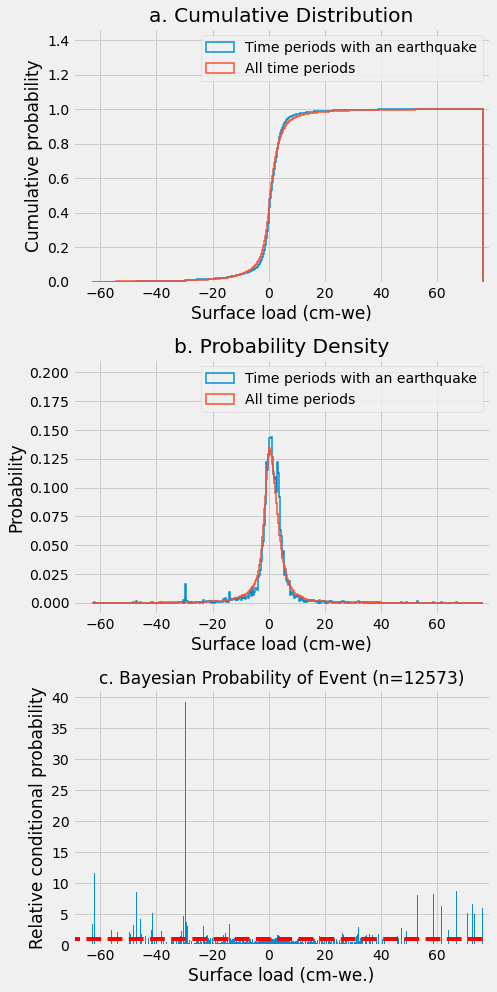

In [95]:
set_of_figures_load(ds['lwe_thickness'].data.flatten(), catalog.dmass,
                    'c. Bayesian Probability of Event (n=12573)','fd')

32
31


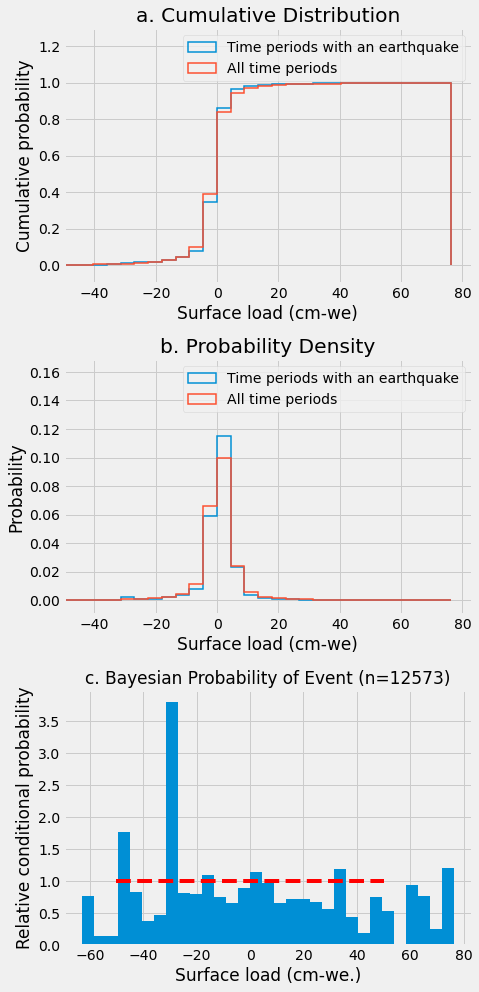

In [34]:
set_of_figures_load(ds['lwe_thickness'].data.flatten(), catalog.dmass,
                    'c. Bayesian Probability of Event (n=12573)','Sturge')

## Correlation between mainshocks and surface mass loading

#### Both statistical tests produce p-values < 0.05, which indicate that the two samples are not drawn from the same distribution. This means that the distribution of surface mass load during earthquake occurrence is significantly different from background.

In [11]:
# takes a long time to run (has already been run for 2002-04-16 to 2022-01-16)
# loadquakes.calc_stats(np.array(mainshock.dmass),np.array(ds['lwe_thickness'].data.flatten()))

{'cvm': CramerVonMisesResult(statistic=18.38713838188511, pvalue=3.178242002910281e-09),
 'ks': KstestResult(statistic=0.0833189806824356, pvalue=0.0010844083570850202),
 'median_all': 0.749170696239575,
 'median_eq': array(0.2847398),
 'mean_all': -0.65387517841372,
 'mean_eq': 0.44100372833838036,
 'mean_all_minus_mean_eq': -1.0948789067521003,
 'median_all_minus_median_eq': 0.46443089594810544}

/home/amand4/.local/lib/python3.9/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


71


/home/amand4/.local/lib/python3.9/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


71
70


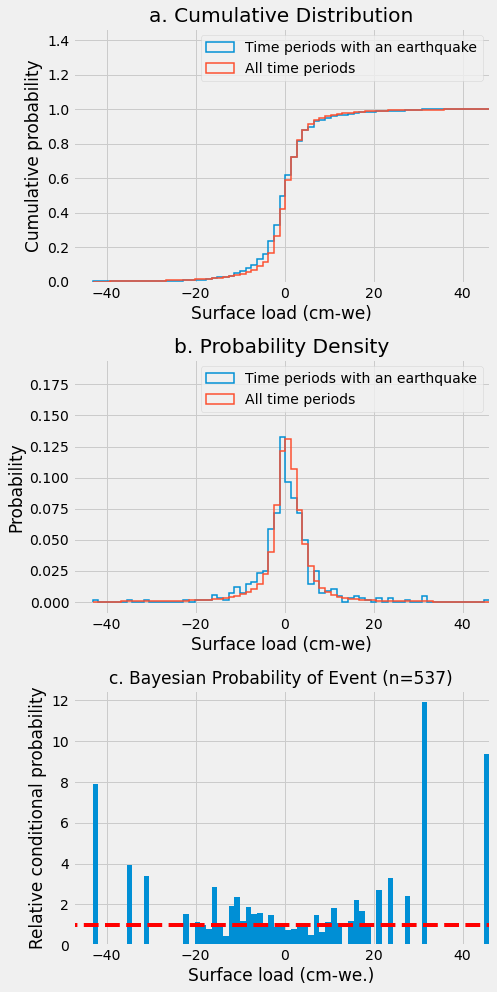

In [175]:
importlib.reload(loadquakes)

set_of_figures_load(ds['lwe_thickness'].data.flatten(), mainshock.dmass,
                    'c. Bayesian Probability of Event (n=537)','fd')

#### The conditional probability will change quantitatively depending on the bin size. However, the same qualitative distribution remains, where there is a higher relative conditional probability during periods of large loading and unloading. 

#### Here, we calculate the Bayesian probability using two different bin sizes which are calculated via two methods:

##### a. Sturge's Rule
##### b. Freedman-Diaconis Rule


21
20


/home/amand4/.local/lib/python3.9/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


71
70


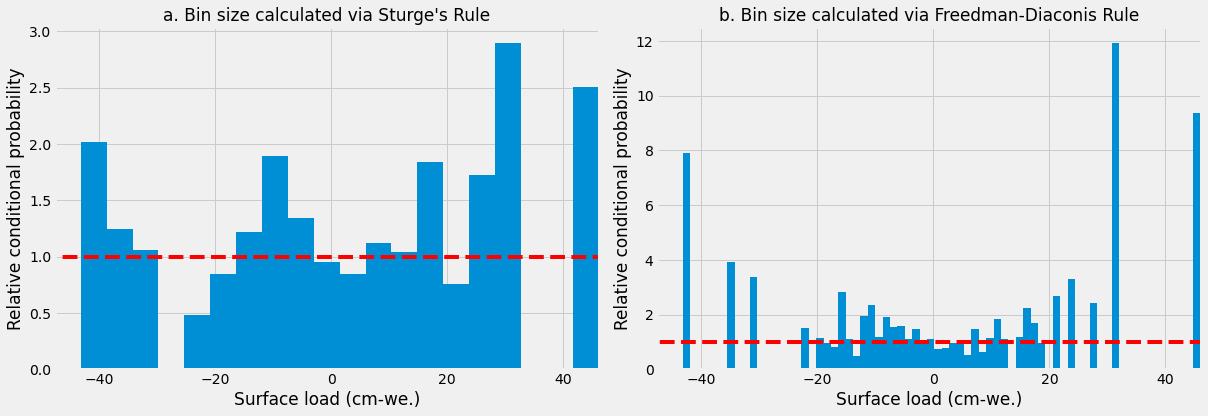

In [79]:
importlib.reload(loadquakes)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(17,6))

plt.style.use('fivethirtyeight')
    
loadquakes.plot_bayes(ds['lwe_thickness'].data.flatten(), mainshock.dmass, ax1,
                      "a. Bin size calculated via Sturge's Rule", method='Sturge')

loadquakes.plot_bayes(ds['lwe_thickness'].data.flatten(), mainshock.dmass, ax2,
                      "b. Bin size calculated via Freedman-Diaconis Rule", method='fd')

fig.tight_layout()


## Mapping earthquakes with high conditional probability

### First, calculate the conditional probability of each mainshock

<ipython-input-69-497784ca765f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock['cp'] = conditional_probability


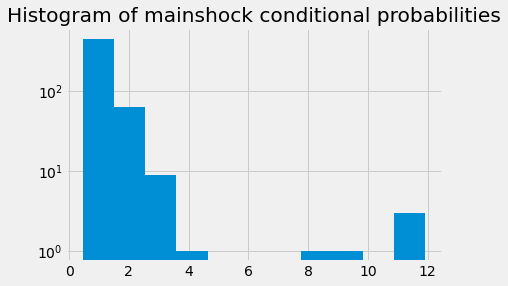

In [69]:
conditional_probability = loadquakes.get_cond_probability(
                            np.array(ds['lwe_thickness'].data.flatten()),
                            np.array(mainshock.dmass), np.array(mainshock.dmass), 'fd')
mainshock['cp'] = conditional_probability
fig,ax=plt.subplots()
plt.hist(np.array(mainshock['cp']),11)
plt.title('Histogram of mainshock conditional probabilities')
plt.yscale('log')

In [70]:
from scipy.stats import iqr
iqr(mainshock['cp'])

0.680382701562655

In [72]:
np.median(mainshock.cp)

1.0637306960958595

### The relative conditional probability for the declustered catalog has a median of is 1.06 and an IQR of 0.68. We use the addition of these values as the threshold to categorize an event as a SLIQ.                       

In [180]:
high = mainshock[mainshock['cp']>1.74]

In [181]:
len(high)

49

In [102]:
high.sort_values('cp')

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,dmass,cp
160,162,-50.3221,-72.2500,2021-10-13 07:55:29.195,5.4,POINT (-50.3221 -72.25),5.4,0.0,6.907373e-11,0.250172,0.749828,1.0,11.095147714953317,1.821275
11970,11972,42.9460,72.7640,2003-05-22 18:11:56.980,5.5,POINT (42.946 72.764),5.4,0.0,6.907373e-11,0.751717,0.248283,1.0,10.984403145527086,1.821275
8119,8121,44.5550,10.4100,2008-12-23 15:24:22.470,5.4,POINT (44.555 10.41),5.4,0.0,6.907373e-11,0.286986,0.713014,1.0,11.08542267087129,1.821275
6639,6641,8.5960,-76.8550,2011-03-02 18:50:49.410,5.7,POINT (8.596 -76.855),5.4,0.0,6.907373e-11,0.840350,0.159650,1.0,10.581914699940025,1.821275
5993,5995,27.7300,88.1550,2011-09-18 12:40:51.830,6.9,POINT (27.73 88.155),5.4,0.0,6.907373e-11,0.713242,0.286758,1.0,11.201337641152765,1.821275
4751,4753,36.5757,86.8448,2013-11-23 23:30:42.550,5.4,POINT (36.5757 86.84480000000001),5.4,0.0,6.907373e-11,0.719846,0.280154,1.0,10.925676856768721,1.821275
3777,3779,-25.3727,154.2281,2015-07-29 23:41:40.420,5.5,POINT (-25.3727 154.2281),5.4,0.0,6.907373e-11,0.341893,0.658107,1.0,10.659763094850273,1.821275
11315,11317,12.7020,-44.4900,2004-05-11 23:58:54.410,5.5,POINT (12.702 -44.49),5.4,0.0,6.907373e-11,0.887444,0.112556,1.0,-8.232435619738212,1.897861
10596,10598,7.1020,-34.1200,2005-03-24 07:33:53.040,5.4,POINT (7.102 -34.12),5.4,0.0,6.907373e-11,0.532074,0.467926,1.0,-7.5961758629257226,1.897861
6958,6960,35.4900,54.4700,2010-08-27 19:23:49.500,5.8,POINT (35.49 54.47),5.4,0.0,6.907373e-11,0.666924,0.333076,1.0,-7.723536653543455,1.897861


In [103]:
high.sort_values('magnitude')

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,dmass,cp
160,162,-50.3221,-72.2500,2021-10-13 07:55:29.195,5.4,POINT (-50.3221 -72.25),5.4,0.0,6.907373e-11,0.250172,0.749828,1.0,11.095147714953317,1.821275
3230,3232,41.4928,-29.3334,2016-07-14 08:36:29.110,5.4,POINT (41.4928 -29.3334),5.4,0.0,6.907373e-11,0.614368,0.385632,1.0,-7.638740556081757,1.897861
4582,4584,4.1909,86.7252,2014-03-27 04:00:15.540,5.4,POINT (4.1909 86.7252),5.4,0.0,6.907373e-11,0.756849,0.243151,1.0,-11.71227395695825,1.936980
4751,4753,36.5757,86.8448,2013-11-23 23:30:42.550,5.4,POINT (36.5757 86.84480000000001),5.4,0.0,6.907373e-11,0.719846,0.280154,1.0,10.925676856768721,1.821275
8119,8121,44.5550,10.4100,2008-12-23 15:24:22.470,5.4,POINT (44.555 10.41),5.4,0.0,6.907373e-11,0.286986,0.713014,1.0,11.08542267087129,1.821275
10596,10598,7.1020,-34.1200,2005-03-24 07:33:53.040,5.4,POINT (7.102 -34.12),5.4,0.0,6.907373e-11,0.532074,0.467926,1.0,-7.5961758629257226,1.897861
1874,1876,27.1986,96.9185,2018-11-28 10:17:06.970,5.4,POINT (27.1986 96.91849999999999),5.4,0.0,6.907373e-11,0.880594,0.119406,1.0,-11.787422681037986,1.936980
1408,1410,33.0779,73.7936,2019-09-24 11:01:54.990,5.4,POINT (33.0779 73.7936),5.4,0.0,6.907373e-11,0.869885,0.130115,1.0,-16.050166577340917,2.832101
209,211,29.1944,105.3650,2021-09-15 20:33:31.851,5.4,POINT (29.1944 105.365),5.4,0.0,6.907373e-11,0.890814,0.109186,1.0,24.034845793439793,3.285261
1714,1716,-3.2806,90.2747,2019-03-10 07:53:20.170,5.5,POINT (-3.2806 90.2747),5.4,0.0,6.907373e-11,0.592813,0.407187,1.0,-8.509723310573076,1.897861


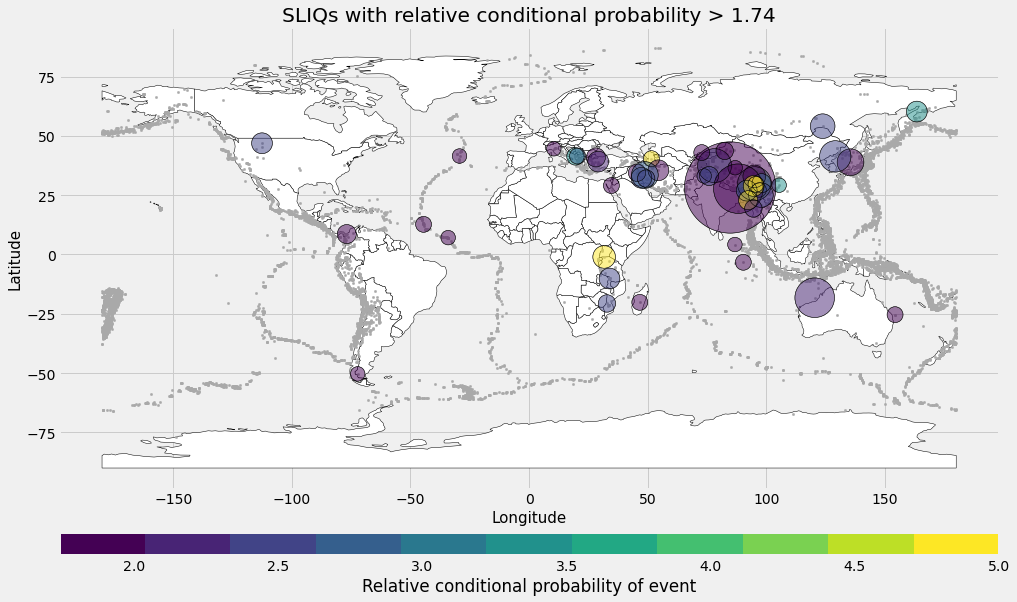

In [172]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
# c = [0.5, 0.5, 0.5]
def probability_map_cb(events,color,label):

    gdf = gpd.GeoDataFrame(events,
                           geometry=gpd.points_from_xy(events.longitude, 
                                                       events.latitude))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    ax.scatter(catalog.longitude, catalog.latitude, c="darkgrey", s=20,marker=".")
    cmap = cm.get_cmap('viridis', 11)    # 11 discrete colors
    gdf.plot(ax=ax,cax=cax,alpha=0.5,column=color,cmap=cmap,legend=True,
             edgecolor='k',
             markersize = 1e-5*(events.magnitude)**10,
             legend_kwds={'label': "Relative conditional probability of event",
                            'orientation': "horizontal"},
            vmax=5,
            vmin=1.74)
    gdf.plot(ax=ax,facecolor="None",
         edgecolor='k',
         markersize = 1e-5*(events.magnitude)**10)
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    ax.set_title(label)
    plt.show()

probability_map_cb(high,high.cp,
                'SLIQs with relative conditional probability > 1.74')

In [195]:
montana = high[high['longitude']<-100]
montana

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,dmass,cp
2683,2685,46.8811,-112.5753,2017-07-06 06:30:17,5.8,POINT (46.8811 -112.5753),5.4,0.0,6.907373e-11,0.179418,0.820582,1.0,-10.376435638728333,2.35414


# Correlation between earthquakes and random data
##### *mean and std deviation of random array same as GRACE data 

In [39]:
np.mean(ds['lwe_thickness'])

<xarray.DataArray 'lwe_thickness' ()>
array(-0.65387518)

In [40]:
np.std(ds['lwe_thickness'])

<xarray.DataArray 'lwe_thickness' ()>
array(25.49255185)

In [41]:
random_load1 = np.random.normal(loc=-0.65387518, scale=25.49255185, size=(205, 360, 720))

In [42]:
ds_random = ds

In [43]:
ds_random = ds_random.assign(load=ds_random['lwe_thickness'] - ds_random['lwe_thickness'] + random_load1)

In [44]:
# earthquake catalog

mainshock_random = catalog[catalog['P_triggered']<.9]

In [45]:
def get_mass_random(eq):
    mass_change = ds_random.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["load"]
    return mass_change.data
  
mainshock_random['dmass'] = mainshock_random.apply(lambda row: get_mass_random(row), axis=1)

<ipython-input-45-1efc1d20fd8f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock_random['dmass'] = mainshock_random.apply(lambda row: get_mass_random(row), axis=1)


21
20


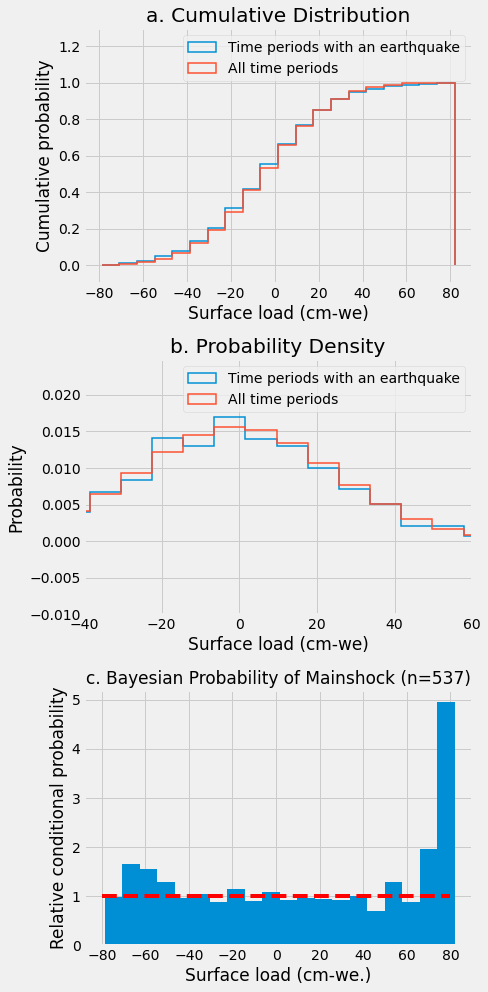

In [47]:
set_of_figures_load(ds_random['load'].data.flatten(), mainshock_random.dmass,'c. Bayesian Probability of Mainshock (n=537)')

In [48]:
stats.ks_2samp(mainshock_random.dmass,ds_random['load'].data.flatten())

KstestResult(statistic=0.02809723441818529, pvalue=0.7793204181206957)